# Move global forcing files to regional domain with new bathymetry

In [30]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.ics_obcs import fill_ocean
from nemo_python.interpolation import neighbours
from nemo_python.utils import distance_btw_points, closest_point
from nemo_python.grid import get_coast_mask, get_icefront_mask

#### Functions

In [4]:
def subset_global(file_path, nemo_mask, fill_ocn=False, time_counter=False):

    ds = xr.open_dataset(f'{file_path}').isel(y=slice(0,453))

    if fill_ocn:
        for var in list(ds.keys()):
            # Check for values that are NaN and in the ocean and fill with nearest neighbour
            # try:
            ds_filled = fill_ocean(ds.isel(time_counter=0), var, nemo_mask, dim='2D', fill_val=0)
            # except:
                # ds_filled = fill_ocean(ds.isel(time_counter=0, nav_lev=0), var, nemo_mask, dim='2D', fill_val=0)
            ds[var]   = ('time_counter','y','x'), ds_filled[var].values[np.newaxis, ...]   

    for var in list(ds.keys()):
        # Then fill any NaN values with 0
        ds[var] = xr.where(np.isnan(ds[var]), 0, ds[var])
    
    new_file_path = file_path.replace(file_path.split('/')[-1], f"AntArc_{file_path.split('/')[-1]}") 
    
    if time_counter:
        ds.to_netcdf(f"{new_file_path}", unlimited_dims='time_counter')
    else:
        ds.to_netcdf(f"{new_file_path}")
    
    return ds

In [16]:
# sum(sum(np.isnan(iwm_ds.isel(y=slice(0,453), time_counter=0).values)))

In [4]:
# iwm_powerbot_filled = fill_ocean(iwm_ds.isel(y=slice(0,453), time_counter=0), 'power_bot', mesh_new)

### Main

In [11]:
domain_old   = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-old.nc')
domain_new   = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20231025-filledlakes.nc')
mesh_new     = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025-filledlakes.nc')

In [6]:
folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/misc-forcing/'

# Internal wave field:
iwm_ds       = subset_global(f'{folder}eORCA025_iwm_b0.2_v1.0_nohls.nc'     , mesh_new, fill_ocn=True , time_counter=True)
# Bottom friction / turbulence:
shlat2d_ds   = subset_global(f'{folder}eORCA025_shlat2d_v0.2_nohls.nc'      , mesh_new, fill_ocn=False, time_counter=False)
bfr2d_ds     = subset_global(f'{folder}eORCA025_bfr2d_v0.2_nohls.nc'        , mesh_new, fill_ocn=False, time_counter=True)
# Distance to the coast:
distcoast_ds = subset_global(f'{folder}eORCA025_distcoast_b0.2_v0.0_nohls.nc', mesh_new, fill_ocn=True, time_counter=True)

#### calving

In [7]:
# Runoff:
# 'eORCA025_runoff_b0.2_v0.0_nohls.nc'
# Calving:
# 'eORCA025_calving_b0.2_v2.3_nohls.nc'
calving = xr.open_dataset(f'{folder}eORCA025_calving_b0.2_v2.3_nohls.nc').isel(time_counter=0, y=slice(0,453))

In [14]:
# identify non-zero calving points that are not icefront_mask_ocn 
# check whether these points are ocean points
# ---> true: check whether within 1-2 grid cell range of coastline --> if that's true keep as is, else move to within closer distance to the coastline
# ---> false: if point is in icefront_mask_ice, move to the nearest icefront_mask_ocn point. 
#             if point is in coast_mask, move to nearest icefront_mask_ocn point


def calving_at_coastline(calving, mask):
    
    calving   = xr.where(calving > 0, calving, np.nan)

    # Boolean arrays to identify regions:
    ocean     = (mask.tmask.isel(time_counter=0, nav_lev=0) == 1)
    iceshelf  = (mask.tmaskutil.isel(time_counter=0) - mask.tmask.isel(time_counter=0, nav_lev=0)).astype(bool);
    land      = (mask.tmaskutil.isel(time_counter=0) == 0)

    # Cases where calving does not occur at the ocean edge of the icefront:
    icefront_mask_ocn = get_icefront_mask(mask, side='ocean')
    calving_ocn  = xr.where((~icefront_mask_ocn & ocean), calving, np.nan)  
    calving_land = xr.where(land      , calving, np.nan)  # calving occurs on land
    calving_ice  = xr.where(iceshelf  , calving, np.nan)  # calving occurs on ice shelf

    # For calving in ocean, check distance to nearest coastline with iceshelf
    # distance_btw_points()
    
    # Move to nearest ocean point:

    return calving_ocn, calving_land, calving_ice


In [52]:
# Function shifts the x,y location of a calving point to the nearest iceshelf front ocean point 
# calving: xarray calving dataset
# mask: locations of cells that need to be shifted
# mesh: xarray dataset of nemo mesh mask file (contains lon, lat)
def shift_calving(calving, mask, mesh, icefront_coord, max_distance=11000):
    x, y        = np.meshgrid(mesh_new.nav_lon.x, mesh_new.nav_lon.y)
    calving_x   = x[(~np.isnan(mask))]
    calving_y   = y[(~np.isnan(mask))]
    calving_new = np.empty(mask.shape); calving_new[:] = np.nan;

    # For each land iceberg calving point, check distance to nearest iceshelf front and move closer if possible:
    for index in list(zip(calving_y, calving_x)):
    
        calving_coord = (mesh.nav_lon.values[index], mesh.nav_lat.values[index])
        distances     = distance_btw_points(calving_coord, icefront_coord)

        # only move cell if it is within a certain distance
        if np.min(np.abs(distances)) < max_distance:     
            new_x         = icefront_x[np.argmin(np.abs(distances))]
            new_y         = icefront_y[np.argmin(np.abs(distances))]
            # Move calving to the nearest icefront point
            calving_new[new_y, new_x] = calving.soicbclv.values[index]    

    return calving_new

In [59]:
x_plot, y_plot = np.meshgrid(mesh_new.x, mesh_new.y)
calving_p = np.ma.masked_where(calving.soicbclv.values==0, calving.soicbclv.values)
calving_x = np.ma.masked_where(calving.soicbclv.values==0, x_plot)
calving_y = np.ma.masked_where(calving.soicbclv.values==0, y_plot)

In [15]:
calving_ocn, calving_land, calving_ice = calving_at_coastline(calving.soicbclv, mesh_new)

coast_mask        = get_coast_mask(mesh_new)
icefront_mask_ice = get_icefront_mask(mesh_new, side='ice')
icefront_mask_ocn = get_icefront_mask(mesh_new, side='ocean')

In [53]:
calv_ocn_new  = shift_calving(calving, calving_ocn, mesh_new, icefront_coord)  # shift calving points that are in the ocean to the iceshelf edge
calv_land_new = shift_calving(calving, calving_land, mesh_new, icefront_coord) # shift calving points that are on land to the ocean
calv_ice_new  = shift_calving(calving, calving_ice, mesh_new, icefront_coord)  # shift calving points that are on ice to the ocean

### these functions seem to work correctly

In [60]:
calving_nonocnx = np.ma.masked_where(icefront_mask_ocn, calving_x)
calving_nonocny = np.ma.masked_where(icefront_mask_ocn, calving_y)

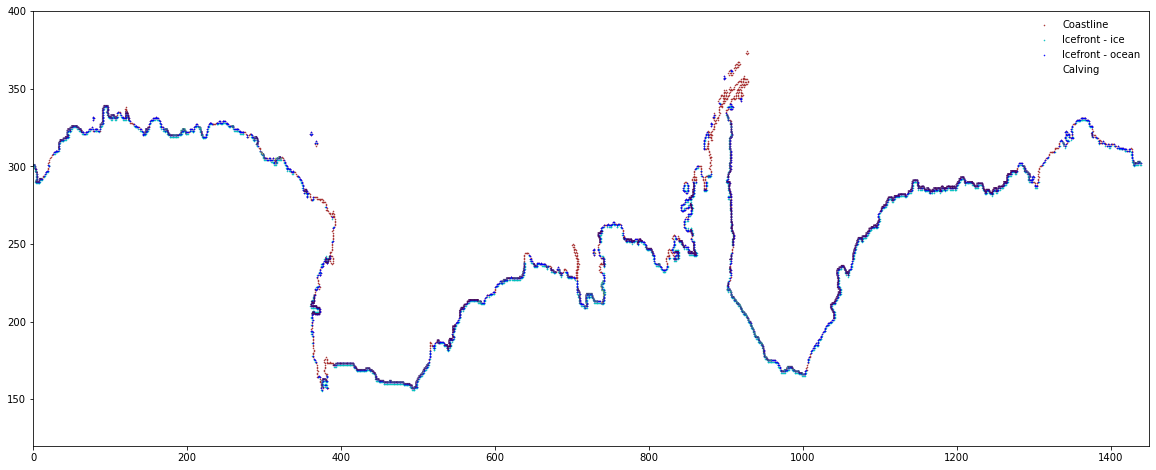

In [61]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.set_xlim(0,1450)
ax.set_ylim(120,400)

x_plot, y_plot = np.meshgrid(mesh_new.x, mesh_new.y)
coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x_plot); coast_y = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y_plot);
isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x_plot); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y_plot);
isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x_plot); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y_plot);
ax.scatter(coast_x, coast_y, c='brown', s=0.3, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c', s=0.3, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b', s=0.3, label='Icefront - ocean');
ax.scatter(calving_x, calving_y, c=calving_p, s=0.3, label='Calving')

ax.legend(frameon=False)

In [65]:
calving_ocn_newx  = np.ma.masked_where(np.isnan(calv_ocn_new),  calving_x)
calving_ocn_newy  = np.ma.masked_where(np.isnan(calv_ocn_new),  calving_y)
calving_land_newx = np.ma.masked_where(np.isnan(calv_land_new), calving_x)
calving_land_newy = np.ma.masked_where(np.isnan(calv_land_new), calving_y)
calving_ice_newx  = np.ma.masked_where(np.isnan(calv_ice_new),  calving_x)
calving_ice_newy  = np.ma.masked_where(np.isnan(calv_ice_new),  calving_y)

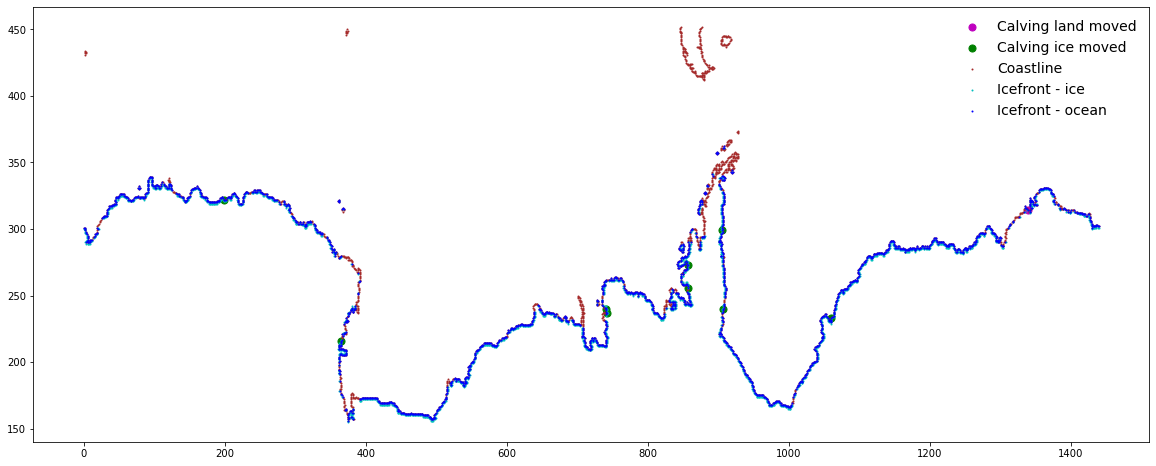

In [70]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
# ax.set_xlim(1100,1200)
# ax.set_ylim(265,300)

x_plot, y_plot = np.meshgrid(mesh_new.x, mesh_new.y)
coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x_plot); coast_y = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y_plot);
isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x_plot); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y_plot);
isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x_plot); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y_plot);
# ax.scatter(calving_nonocnx, calving_nonocny, c='w', s=10, edgecolor='k', label='Calving');
# ax.scatter(calving_ocn_newx   , calving_ocn_newy   , c='r', s=20, edgecolor='r', label='Calving moved');
ax.scatter(calving_land_newx  , calving_land_newy  , c='m', s=50, edgecolor='m', label='Calving land moved');
ax.scatter(calving_ice_newx   , calving_ice_newy   , c='g', s=50, edgecolor='g', label='Calving ice moved');
ax.scatter(coast_x , coast_y, c='brown', s=1, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c', s=1, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b', s=1, label='Icefront - ocean');

ax.legend(frameon=False, fontsize=14)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.set_xlim(700,780)
ax.set_ylim(200,270)

x_plot, y_plot = np.meshgrid(mesh_new.x, mesh_new.y)
coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x_plot); coast_y = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y_plot);
isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x_plot); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y_plot);
isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x_plot); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y_plot);
ax.scatter(calving_nonocnx, calving_nonocny, c='w', s=50, edgecolor='k', label='Calving');
ax.scatter(calving_ocn_newx   , calving_ocn_newy   , c='r', s=80, edgecolor='r', label='Calving ocean moved');
ax.scatter(calving_land_newx  , calving_land_newy  , c='m', s=80, edgecolor='m', label='Calving land moved');
ax.scatter(calving_ice_newx   , calving_ice_newy   , c='g', s=80, edgecolor='g', label='Calving ice moved');
ax.scatter(coast_x , coast_y , c='brown', s=12, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c', s=12, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b', s=12, label='Icefront - ocean');

ax.legend(frameon=False, fontsize=14)

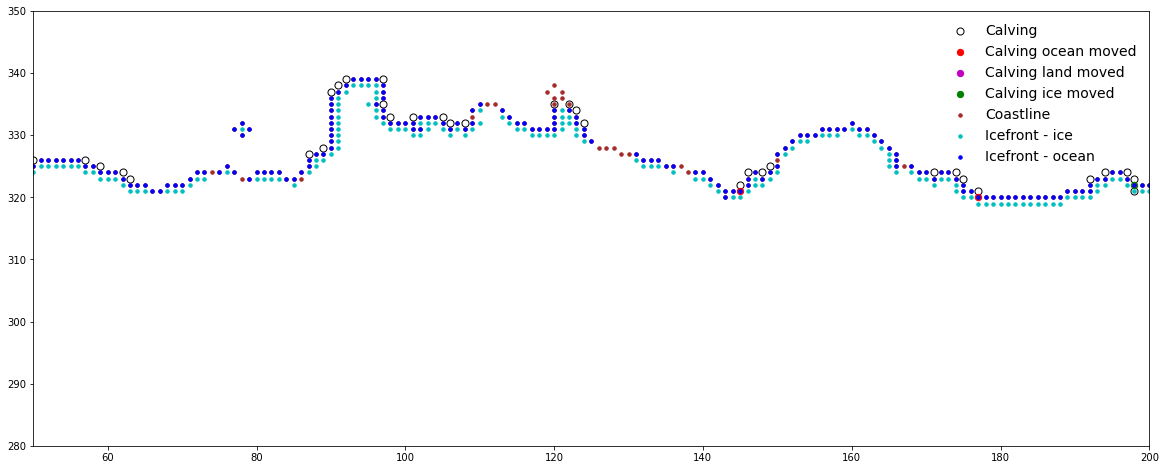

In [71]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.set_xlim(50,200)
ax.set_ylim(280,350)

x_plot, y_plot = np.meshgrid(mesh_new.x, mesh_new.y)
coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x_plot); coast_y = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y_plot);
isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x_plot); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y_plot);
isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x_plot); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y_plot);
ax.scatter(calving_nonocnx, calving_nonocny, c='w', s=50, edgecolor='k', label='Calving');
ax.scatter(calving_ocn_newx   , calving_ocn_newy   , c='r', s=40, edgecolor='r', label='Calving ocean moved');
ax.scatter(calving_land_newx  , calving_land_newy  , c='m', s=40, edgecolor='m', label='Calving land moved');
ax.scatter(calving_ice_newx   , calving_ice_newy   , c='g', s=40, edgecolor='g', label='Calving ice moved');
ax.scatter(coast_x , coast_y , c='brown', s=12, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c', s=12, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b', s=12, label='Icefront - ocean');

ax.legend(frameon=False, fontsize=14)

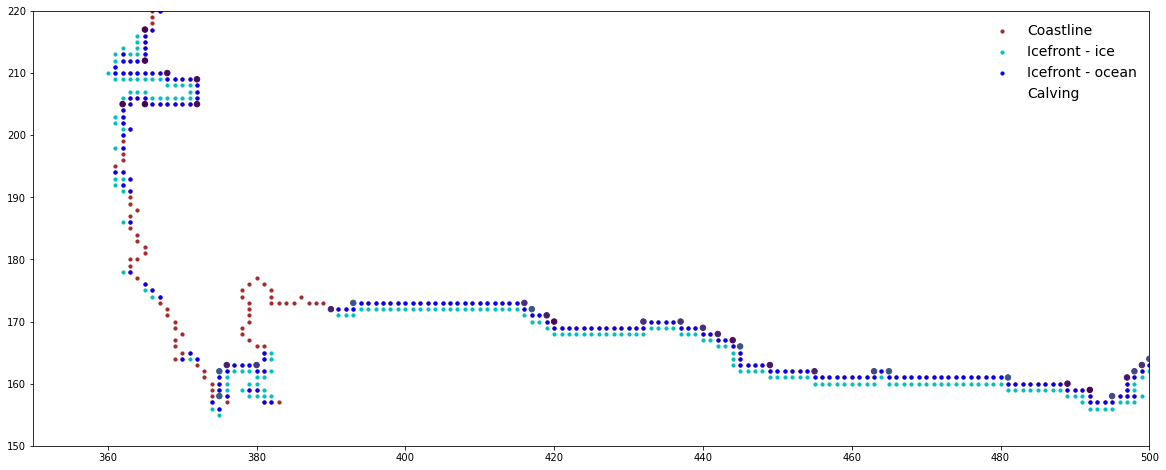

In [29]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.set_xlim(350,500)
ax.set_ylim(150,220)

x_plot, y_plot = np.meshgrid(mesh_new.x,'r' mesh_new.y)
coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x_plot); coast_y = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y_plot);
isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x_plot); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y_plot);
isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x_plot); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y_plot);
ax.scatter(coast_x, coast_y, c='brown', s=10, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c', s=10, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b', s=10, label='Icefront - ocean');
ax.scatter(calving_nonocnx, calving_nonocny, c=calving_p, s=30, label='Calving');

ax.legend(frameon=False, fontsize=14)